# Pneumonia Detection from Chest X-Ray Images



Dataset available on kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Install and load modules

In [1]:
# !pip install timm torchsummary tqdm numpy matplotlib torch torchvision kagglehub

In [2]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 18.4 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torchmetrics

## Download the dataset

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:23<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [5]:
!pwd

/content


In [6]:
! cp -r /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 /content/

## Define problem parameters

In [7]:
class config:

    epochs = 1                                     # No. of epochs of training the model
    lr_custom = 0.000005                           # Learning rate for custom model
    lr_pretrained = 0.00001                        # Learning rate for pretrained model
    batch_size = 128                               # Batch Size For Dataset

    model_name = 'tf_efficientnet_b7.ap_in1k'      # Model name (We are going to import model from timm)

    img_size = 224

    in_mean = [0.485, 0.456, 0.406]  # ImageNet dataset mean
    in_std = [0.229, 0.224, 0.225]   # ImageNet dataset std

    pn_mean = [0.4752]  # Pneumonia dataset mean
    pn_std = [0.2234]   # Pneumonia dataset std

    # Going to be use for loading dataset
    data_dir = '/content/2/chest_xray/chest_xray'   # Data Directory
    test_dir = 'test'                               # Test folder name in data directory
    train_dir = 'train'                             # Train folder name in data directory
    valid_dir = 'val'                               # Valid folder name in data directory

## Choose available device

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device: {device}")

if torch.cuda.is_available():
    !nvidia-smi

device: cuda
Mon Nov 11 05:27:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

## Image transformation pipelines

In [9]:
from torchvision import transforms as T, datasets
from torch.utils.data import Dataset

In [10]:
class Gray2RGB:
    def __call__(self, image):
        return image.repeat(3, 1, 1) # Repeat the single channel across 3 channels to convert to RGB

train_transform_custom = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=(-20, 20)),
                            T.ToTensor(),
                            T.Normalize(config.pn_mean, config.pn_std),
                            Gray2RGB(),
                        ])

valid_transform_custom = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.ToTensor(),
                            T.Normalize(config.pn_mean, config.pn_std),
                            Gray2RGB(),
                        ])

test_transform_custom = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.ToTensor(),
                            T.Normalize(config.pn_mean, config.pn_std),
                            Gray2RGB(),
                        ])

In [11]:
train_transform_pretrained = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=(-20, 20)),
                            T.ToTensor(),
                            Gray2RGB(),
                            T.Normalize(config.in_mean, config.in_std)
                        ])

valid_transform_pretrained = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.ToTensor(),
                            Gray2RGB(),
                            T.Normalize(config.in_mean, config.in_std)
                        ])

test_transform_pretrained = T.Compose([
                            T.Resize(size=(config.img_size, config.img_size)),
                            T.ToTensor(),
                            Gray2RGB(),
                            T.Normalize(config.in_mean, config.in_std)
                        ])

## Pre-load datasets

In [12]:
train_path = os.path.join(config.data_dir, config.train_dir)
valid_path = os.path.join(config.data_dir, config.valid_dir)
test_path = os.path.join(config.data_dir, config.test_dir)

In [13]:
trainset_temp = datasets.ImageFolder(train_path, transform=None)
validset_temp = datasets.ImageFolder(valid_path, transform=None)
testset_temp = datasets.ImageFolder(test_path, transform=None)

In [14]:
print(f"Train set size : {len(trainset_temp)}")
print(f"Valid set size : {len(validset_temp)}")
print(f"Test set size : {len(testset_temp)}")

Train set size : 5216
Valid set size : 16
Test set size : 624


In [15]:
# Loading the datasets into the memory to boost performance

train_img_list = []
train_label_list = []
for img, label in trainset_temp:
    img = img.convert("L")
    train_img_list.append(img)
    train_label_list.append(label)

valid_img_list = []
valid_label_list = []
for img, label in validset_temp:
    img = img.convert("L")
    valid_img_list.append(img)
    valid_label_list.append(label)

test_img_list = []
test_label_list = []
for img, label in testset_temp:
    img = img.convert("L")
    test_img_list.append(img)
    test_label_list.append(label)

## Create custom dataset

In [16]:
class CustomDataset(Dataset):

    def __init__(self, img_list, label_list, transform=None):
        super().__init__()
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        image = self.img_list[index]
        label = self.label_list[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
trainset_custom = CustomDataset(train_img_list, train_label_list, train_transform_custom)
trainset_pretrained = CustomDataset(train_img_list, train_label_list, train_transform_pretrained)

validset_custom = CustomDataset(valid_img_list, valid_label_list, valid_transform_custom)
validset_pretrained = CustomDataset(valid_img_list, valid_label_list, valid_transform_pretrained)

testset_custom = CustomDataset(test_img_list, test_label_list, test_transform_custom)
testset_pretrained = CustomDataset(test_img_list, test_label_list, test_transform_pretrained)

## Count samples in each class

In [18]:
from collections import Counter

# Function for counting the number of samples in each class
def count_classes(dataset):
    label_counts = Counter()
    for _, label in dataset:
        label_counts[label] += 1
    return label_counts

In [19]:
label_counts_train = count_classes(trainset_custom)

print(label_counts_train)  # Counter({1: 3875, 0: 1341})

Counter({1: 3875, 0: 1341})


In [20]:
label_counts_valid = count_classes(validset_custom)

print(label_counts_valid)

Counter({0: 8, 1: 8})


In [21]:
label_counts_test = count_classes(testset_custom)

print(label_counts_test)

Counter({1: 390, 0: 234})


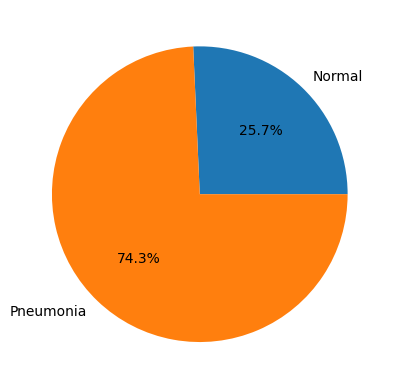

In [22]:
sizes = [label_counts_train[0], label_counts_train[1]]
labels = ['Normal', 'Pneumonia']

plt.pie(sizes, labels=labels, autopct='%1.1f%%');

## Calculate the weight for each class

In [23]:
# calculating weight for each class
from sklearn.utils.class_weight import compute_class_weight

# Get class labels from dataset
y_labels = [label for _, label in trainset_custom]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)

# Convert to torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f'class_weights: {class_weights}')

class_weights: tensor([1.9448, 0.6730])


In [24]:
def show_image(image, label='-', mean=None, std=None):

    image = image.permute(1, 2, 0)

    if mean and std:
        mean = torch.FloatTensor(mean)
        std = torch.FloatTensor(std)
        image = image*std + mean
        image = torch.clip(image, 0, 1)
        image = image.numpy()

    plt.imshow(image, cmap="gray")
    plt.title(label)

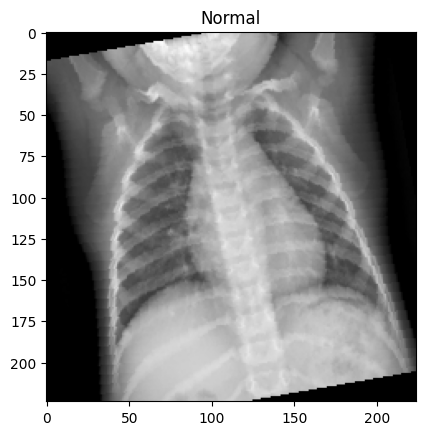

In [25]:
sample_img, sample_label = trainset_custom[2]

show_image(sample_img, labels[sample_label], config.pn_mean, config.pn_std)

## Load dataset into batches

In [26]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [27]:
train_loader_custom = DataLoader(trainset_custom, batch_size=config.batch_size, shuffle=True)
valid_loader_custom = DataLoader(validset_custom, batch_size=config.batch_size, shuffle=False)
test_loader_custom = DataLoader(testset_custom, batch_size=config.batch_size, shuffle=False)

In [28]:
train_loader_pretrained = DataLoader(trainset_pretrained, batch_size=config.batch_size, shuffle=True)
valid_loader_pretrained = DataLoader(validset_pretrained, batch_size=config.batch_size, shuffle=False)
test_loader_pretrained = DataLoader(testset_pretrained, batch_size=config.batch_size, shuffle=False)

In [29]:
print(f"No. of batches in train loader : {len(train_loader_custom)}")
print(f"No. of batches in valid loader : {len(valid_loader_custom)}")
print(f"No. of batches in test loader : {len(test_loader_custom)}")

No. of batches in train loader : 41
No. of batches in valid loader : 1
No. of batches in test loader : 5


In [30]:
train_iter = iter(train_loader_custom)
sample_batch, sample_batch_label = next(train_iter)

print(f'sample_batch.shape: {sample_batch.shape}')

sample_batch.shape: torch.Size([128, 3, 224, 224])


## Show samples of dataset

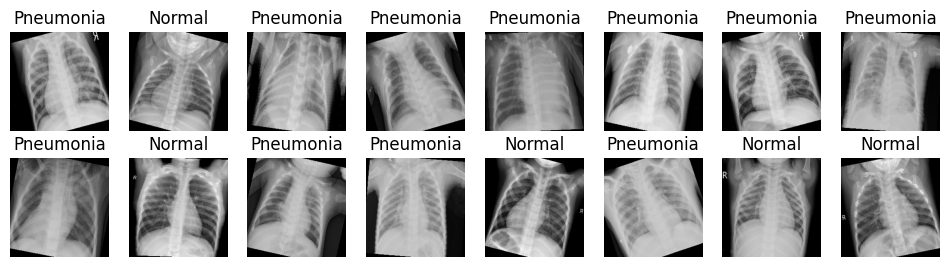

In [31]:
fig, ax = plt.subplots(2, 8, figsize=(12,3))

sample_batch, sample_batch_label = next(iter(train_loader_custom))
for n in range(2):
    for m in range(8):
        image = sample_batch[n*8+m].cpu().permute(1, 2, 0)
        mean = torch.FloatTensor(config.pn_mean)
        std = torch.FloatTensor(config.pn_std)
        image = image*std + mean
        image = torch.clip(image, 0, 1)
        image = image.numpy()

        ax[n,m].imshow(image, cmap="gray")
        ax[n,m].grid(False)
        ax[n,m].axis(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)
        ax[n,m].set_title(f'{labels[sample_batch_label[n*8+m]]}')


## Design custom CNN model

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
# Calculating the size of the final layer before feeding into the linear layer
X = torch.zeros(1, 3, config.img_size, config.img_size)

conv1 = nn.Sequential(
                nn.Conv2d(3, 8, 3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

conv2 = nn.Sequential(
                nn.Conv2d(8, 16, 3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

conv3 = nn.Sequential(
                nn.Conv2d(16, 32, 3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

conv4 = nn.Sequential(
                nn.Conv2d(32, 64, 3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

conv5 = nn.Sequential(
                nn.Conv2d(64, 128, 3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

X = conv1(X)
X = conv2(X)
X = conv3(X)
X = conv4(X)
X = conv5(X)

X.shape # [1, 128, 7, 7]

torch.Size([1, 128, 7, 7])

In [34]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 8, 3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(8),
                        nn.MaxPool2d(2,2))

        self.conv2 = nn.Sequential(
                        nn.Conv2d(8, 16, 3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(16),
                        nn.MaxPool2d(2,2))

        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, 3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2,2))

        self.conv4 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2))

        self.conv5 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2))

        self.fc = nn.Sequential(
                    nn.Linear(128*7*7, 512),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(512),
                    nn.Dropout(0.5),
                    nn.Linear(512, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = ConvolutionalNetwork()

cnn_model.to(device)

ConvolutionalNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride

In [36]:
from torchsummary import summary

summary(cnn_model, input_size=(3, config.img_size, config.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
       BatchNorm2d-3          [-1, 8, 224, 224]              16
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,168
              ReLU-6         [-1, 16, 112, 112]               0
       BatchNorm2d-7         [-1, 16, 112, 112]              32
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,640
             ReLU-10           [-1, 32, 56, 56]               0
      BatchNorm2d-11           [-1, 32, 56, 56]              64
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
             ReLU-14           [-1, 64,

## Define pretrained models for fine-tuning

In [37]:
from torch import nn
import torch.nn.functional as F
import timm

# Models that we will be using:
# tf_efficientnet_b4.ap_in1k
# tf_efficientnet_b7.ap_in1k
# resnet50.tv_in1k
# resnet101.tv_in1k

torch.manual_seed(42)
torch.cuda.manual_seed(42)

config.model_name = 'tf_efficientnet_b7.ap_in1k'

model = timm.create_model(config.model_name, pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [38]:
for param in model.parameters():
    param.requires_grad = False

# Number of in- and out- features for each model:
# 1792 -> 768  -> 256 -> 2   EfficientNet_b4
# 2560 -> 1024 -> 256 -> 2   EfficientNet_b7
# 2048 -> 1024 -> 256 -> 2   ResNet50
# 2048 -> 1024 -> 256 -> 2   ResNet101

# model.classifier for efficientnet family
# model.fc for ResNet family
model.classifier = nn.Sequential(
    nn.Linear(in_features=2560, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2),
)

model.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [39]:
from torchsummary import summary

summary(model, input_size=(3, config.img_size, config.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 64, 112, 112]           1,728
          Identity-2         [-1, 64, 112, 112]               0
              SiLU-3         [-1, 64, 112, 112]               0
    BatchNormAct2d-4         [-1, 64, 112, 112]             128
            Conv2d-5         [-1, 64, 112, 112]             576
          Identity-6         [-1, 64, 112, 112]               0
              SiLU-7         [-1, 64, 112, 112]               0
    BatchNormAct2d-8         [-1, 64, 112, 112]             128
          Identity-9         [-1, 64, 112, 112]               0
           Conv2d-10             [-1, 16, 1, 1]           1,040
             SiLU-11             [-1, 16, 1, 1]               0
           Conv2d-12             [-1, 64, 1, 1]           1,088
          Sigmoid-13             [-1, 64, 1, 1]               0
    SqueezeExcite-14         [-1, 64, 1

## Trainer class for training and validation

In [40]:
# Define a named tuple for metrics
from collections import namedtuple

Metrics = namedtuple('Metrics', ['avg_loss', 'avg_accuracy', 'avg_recall', 'avg_precision', 'avg_f1_score'])

In [41]:
class PneumoniaTrainer():

    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.min_valid_loss = 1e10 # a large number
        self.best_valid_accuracy = 0.
        self.best_valid_recall = 0.
        self.best_valid_precision = 0.
        self.best_valid_f1_score = 0.
        self.device = device
        self.num_classes = 2

    def train_batch_loop(self, train_loader):

        self.model.to(self.device)
        self.model.train()

        total_loss = 0.

        metric_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_recall = torchmetrics.classification.Recall(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_precision = torchmetrics.classification.Precision(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_f1_score = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)

        for images, labels in tqdm(train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            logits = self.model(images)

            loss = self.criterion(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

            accuracy_batch = metric_accuracy(logits, labels)
            recall_batch = metric_recall(logits, labels)
            precision_batch = metric_precision(logits, labels)
            f1_score_batch = metric_f1_score(logits, labels)


        avg_loss = total_loss / len(train_loader)
        avg_accuracy = metric_accuracy.compute().item()
        avg_recall = metric_recall.compute().item()
        avg_precision = metric_precision.compute().item()
        avg_f1_score = metric_f1_score.compute().item()

        metric_accuracy.reset()
        metric_recall.reset()
        metric_precision.reset()
        metric_f1_score.reset()

        return Metrics(avg_loss=avg_loss,
                       avg_accuracy=avg_accuracy,
                       avg_recall=avg_recall,
                       avg_precision=avg_precision,
                       avg_f1_score=avg_f1_score)

    def valid_batch_loop(self, valid_loader):

        self.model.to(self.device)
        self.model.eval() # turns off drop out and batch normalization layers

        total_loss = 0.

        metric_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_recall = torchmetrics.classification.Recall(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_precision = torchmetrics.classification.Precision(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)
        metric_f1_score = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes, average="weighted").to(self.device)

        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                logits = self.model(images)

                loss = self.criterion(logits, labels)

                total_loss += loss.item()

                accuracy_batch = metric_accuracy(logits, labels)
                recall_batch = metric_recall(logits, labels)
                precision_batch = metric_precision(logits, labels)
                f1_score_batch = metric_f1_score(logits, labels)


            avg_loss = total_loss / len(valid_loader)
            avg_accuracy = metric_accuracy.compute().item()
            avg_recall = metric_recall.compute().item()
            avg_precision = metric_precision.compute().item()
            avg_f1_score = metric_f1_score.compute().item()

            metric_accuracy.reset()
            metric_recall.reset()
            metric_precision.reset()
            metric_f1_score.reset()

        return Metrics(avg_loss=avg_loss,
                       avg_accuracy=avg_accuracy,
                       avg_recall=avg_recall,
                       avg_precision=avg_precision,
                       avg_f1_score=avg_f1_score)


    def fit(self, n_epoch, train_loader, valid_loader, save_filename):

        train_loss = []
        train_accuracy = []
        train_recall = []
        train_precision = []
        train_f1_score = []

        valid_loss = []
        valid_accuracy = []
        valid_recall = []
        valid_precision = []
        valid_f1_score = []

        # Early stopping parameters
        patience = 5
        patience_counter = 0

        for i_epoch in range(n_epoch):

            train_metrics = self.train_batch_loop(train_loader)

            valid_metrics = self.valid_batch_loop(valid_loader)

            train_loss.append(train_metrics.avg_loss)
            train_accuracy.append(train_metrics.avg_accuracy)
            train_recall.append(train_metrics.avg_recall)
            train_precision.append(train_metrics.avg_precision)
            train_f1_score.append(train_metrics.avg_f1_score)

            valid_loss.append(valid_metrics.avg_loss)
            valid_accuracy.append(valid_metrics.avg_accuracy)
            valid_recall.append(valid_metrics.avg_recall)
            valid_precision.append(valid_metrics.avg_precision)
            valid_f1_score.append(valid_metrics.avg_f1_score)

            print(f'Epoch: {i_epoch}, Train Loss: {train_metrics.avg_loss:.3f}, Train Acc.: {train_metrics.avg_accuracy:.3f}, ' +
                  f'Train recall: {train_metrics.avg_recall:.3f}, ' +
                  f'Train precision: {train_metrics.avg_precision:.3f}, Train f1_score: {train_metrics.avg_f1_score:.3f}')

            print(f'Epoch: {i_epoch}, Valid Loss: {valid_metrics.avg_loss:.3f}, Valid Acc.: {valid_metrics.avg_accuracy:.3f}, ' +
                  f'Valid recall: {valid_metrics.avg_recall:.3f}, ' +
                  f'Valid precision: {valid_metrics.avg_precision:.3f}, Valid f1_score: {valid_metrics.avg_f1_score:.3f}')

            if valid_metrics.avg_loss < self.min_valid_loss:
                self.min_valid_loss = valid_metrics.avg_loss
                self.best_valid_accuracy = valid_metrics.avg_accuracy
                self.best_valid_recall = valid_metrics.avg_recall
                self.best_valid_precision = valid_metrics.avg_precision
                self.best_valid_f1_score = valid_metrics.avg_f1_score
                patience_counter = 0
                torch.save(self.model.state_dict(), save_filename)
                print(f'Model saved to {save_filename}')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        print(f'\nBest Valid Loss: {self.min_valid_loss:.3f}')
        print(f'Best Valid Accuracy: {self.best_valid_accuracy:.3f}')
        print(f'Best Valid recall: {self.best_valid_recall:.3f}')
        print(f'Best Valid precision: {self.best_valid_precision:.3f}')
        print(f'Best Valid f1_score: {self.best_valid_f1_score:.3f}')

        train_lists = {'train_loss': train_loss,
                       'train_accuracy': train_accuracy,
                       'train_recall': train_recall,
                       'train_precision': train_precision,
                       'train_f1_score': train_f1_score
                       }

        valid_lists = {'valid_loss': valid_loss,
                       'valid_accuracy': valid_accuracy,
                       'valid_recall': valid_recall,
                       'valid_precision': valid_precision,
                       'valid_f1_score': valid_f1_score
                       }


        return train_lists, valid_lists

## Train and fine-tune the models

In [42]:
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=config.lr_custom)
pretrained_optimizer = torch.optim.Adam(model.parameters(), lr=config.lr_pretrained)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

cnn_trainer = PneumoniaTrainer(cnn_model, cnn_optimizer, criterion, device)
pretrained_trainer = PneumoniaTrainer(model, pretrained_optimizer, criterion, device)

print('Training custom CNN model:')
n_epoch = 20
train_lists1, valid_lists1 = cnn_trainer.fit(n_epoch, train_loader_custom, valid_loader_custom, 'pneumonia_cnn_model.pt')

print('Fine-tuning pretrained model:')
n_epoch = 20
save_filename_pretrained = 'pneumonia_pretrained_model_' + config.model_name + '.pt'
train_lists2, valid_lists2  = pretrained_trainer.fit(n_epoch, train_loader_pretrained, valid_loader_pretrained, save_filename_pretrained)


Training custom CNN model:


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.573, Train Acc.: 0.677, Train recall: 0.677, Train precision: 0.779, Train f1_score: 0.698
Epoch: 0, Valid Loss: 1.446, Valid Acc.: 0.500, Valid recall: 0.500, Valid precision: 0.250, Valid f1_score: 0.333
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.392, Train Acc.: 0.785, Train recall: 0.785, Train precision: 0.867, Train f1_score: 0.798
Epoch: 1, Valid Loss: 0.588, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.767, Valid f1_score: 0.746
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.353, Train Acc.: 0.811, Train recall: 0.811, Train precision: 0.879, Train f1_score: 0.823
Epoch: 2, Valid Loss: 0.558, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.327, Train Acc.: 0.825, Train recall: 0.825, Train precision: 0.886, Train f1_score: 0.835
Epoch: 3, Valid Loss: 0.530, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.312, Train Acc.: 0.842, Train recall: 0.842, Train precision: 0.896, Train f1_score: 0.851
Epoch: 4, Valid Loss: 0.514, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.288, Train Acc.: 0.851, Train recall: 0.851, Train precision: 0.899, Train f1_score: 0.859
Epoch: 5, Valid Loss: 0.456, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.767, Valid f1_score: 0.746
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.279, Train Acc.: 0.852, Train recall: 0.852, Train precision: 0.899, Train f1_score: 0.860
Epoch: 6, Valid Loss: 0.430, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.767, Valid f1_score: 0.746
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.268, Train Acc.: 0.867, Train recall: 0.867, Train precision: 0.907, Train f1_score: 0.874
Epoch: 7, Valid Loss: 0.421, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.767, Valid f1_score: 0.746
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.252, Train Acc.: 0.870, Train recall: 0.870, Train precision: 0.908, Train f1_score: 0.877
Epoch: 8, Valid Loss: 0.401, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.817, Valid f1_score: 0.812
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.242, Train Acc.: 0.874, Train recall: 0.874, Train precision: 0.911, Train f1_score: 0.880
Epoch: 9, Valid Loss: 0.405, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.767, Valid f1_score: 0.746


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.235, Train Acc.: 0.880, Train recall: 0.880, Train precision: 0.913, Train f1_score: 0.886
Epoch: 10, Valid Loss: 0.366, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.817, Valid f1_score: 0.812
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.228, Train Acc.: 0.887, Train recall: 0.887, Train precision: 0.916, Train f1_score: 0.893
Epoch: 11, Valid Loss: 0.328, Valid Acc.: 0.938, Valid recall: 0.938, Valid precision: 0.944, Valid f1_score: 0.937
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.217, Train Acc.: 0.889, Train recall: 0.889, Train precision: 0.918, Train f1_score: 0.894
Epoch: 12, Valid Loss: 0.338, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.900, Valid f1_score: 0.873


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.217, Train Acc.: 0.899, Train recall: 0.899, Train precision: 0.923, Train f1_score: 0.904
Epoch: 13, Valid Loss: 0.324, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.817, Valid f1_score: 0.812
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.209, Train Acc.: 0.901, Train recall: 0.901, Train precision: 0.924, Train f1_score: 0.905
Epoch: 14, Valid Loss: 0.310, Valid Acc.: 0.938, Valid recall: 0.938, Valid precision: 0.944, Valid f1_score: 0.937
Model saved to pneumonia_cnn_model.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.204, Train Acc.: 0.909, Train recall: 0.909, Train precision: 0.929, Train f1_score: 0.913
Epoch: 15, Valid Loss: 0.319, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.875, Valid f1_score: 0.875


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.192, Train Acc.: 0.915, Train recall: 0.915, Train precision: 0.932, Train f1_score: 0.918
Epoch: 16, Valid Loss: 0.321, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.900, Valid f1_score: 0.873


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.197, Train Acc.: 0.912, Train recall: 0.912, Train precision: 0.930, Train f1_score: 0.915
Epoch: 17, Valid Loss: 0.346, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.900, Valid f1_score: 0.873


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.185, Train Acc.: 0.917, Train recall: 0.917, Train precision: 0.933, Train f1_score: 0.920
Epoch: 18, Valid Loss: 0.349, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.900, Valid f1_score: 0.873


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.178, Train Acc.: 0.925, Train recall: 0.925, Train precision: 0.938, Train f1_score: 0.928
Epoch: 19, Valid Loss: 0.337, Valid Acc.: 0.875, Valid recall: 0.875, Valid precision: 0.900, Valid f1_score: 0.873
Early stopping triggered.

Best Valid Loss: 0.310
Best Valid Accuracy: 0.938
Best Valid recall: 0.938
Best Valid precision: 0.944
Best Valid f1_score: 0.937
Fine-tuning pretrained model:


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.684, Train Acc.: 0.513, Train recall: 0.513, Train precision: 0.798, Train f1_score: 0.519
Epoch: 0, Valid Loss: 0.663, Valid Acc.: 0.625, Valid recall: 0.625, Valid precision: 0.786, Valid f1_score: 0.564
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.656, Train Acc.: 0.738, Train recall: 0.738, Train precision: 0.866, Train f1_score: 0.755
Epoch: 1, Valid Loss: 0.618, Valid Acc.: 0.688, Valid recall: 0.688, Valid precision: 0.808, Valid f1_score: 0.654
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.615, Train Acc.: 0.797, Train recall: 0.797, Train precision: 0.882, Train f1_score: 0.809
Epoch: 2, Valid Loss: 0.557, Valid Acc.: 0.688, Valid recall: 0.688, Valid precision: 0.808, Valid f1_score: 0.654
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.553, Train Acc.: 0.833, Train recall: 0.833, Train precision: 0.894, Train f1_score: 0.843
Epoch: 3, Valid Loss: 0.490, Valid Acc.: 0.688, Valid recall: 0.688, Valid precision: 0.808, Valid f1_score: 0.654
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.481, Train Acc.: 0.850, Train recall: 0.850, Train precision: 0.901, Train f1_score: 0.859
Epoch: 4, Valid Loss: 0.431, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.410, Train Acc.: 0.865, Train recall: 0.865, Train precision: 0.907, Train f1_score: 0.872
Epoch: 5, Valid Loss: 0.393, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.348, Train Acc.: 0.876, Train recall: 0.876, Train precision: 0.911, Train f1_score: 0.882
Epoch: 6, Valid Loss: 0.368, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.303, Train Acc.: 0.891, Train recall: 0.891, Train precision: 0.917, Train f1_score: 0.895
Epoch: 7, Valid Loss: 0.356, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.275, Train Acc.: 0.898, Train recall: 0.898, Train precision: 0.920, Train f1_score: 0.902
Epoch: 8, Valid Loss: 0.342, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.249, Train Acc.: 0.900, Train recall: 0.900, Train precision: 0.922, Train f1_score: 0.904
Epoch: 9, Valid Loss: 0.340, Valid Acc.: 0.750, Valid recall: 0.750, Valid precision: 0.833, Valid f1_score: 0.733
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.228, Train Acc.: 0.906, Train recall: 0.906, Train precision: 0.924, Train f1_score: 0.909
Epoch: 10, Valid Loss: 0.330, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.212, Train Acc.: 0.913, Train recall: 0.913, Train precision: 0.929, Train f1_score: 0.916
Epoch: 11, Valid Loss: 0.328, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.200, Train Acc.: 0.922, Train recall: 0.922, Train precision: 0.936, Train f1_score: 0.925
Epoch: 12, Valid Loss: 0.317, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.196, Train Acc.: 0.921, Train recall: 0.921, Train precision: 0.934, Train f1_score: 0.924
Epoch: 13, Valid Loss: 0.317, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.189, Train Acc.: 0.922, Train recall: 0.922, Train precision: 0.934, Train f1_score: 0.924
Epoch: 14, Valid Loss: 0.315, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.179, Train Acc.: 0.927, Train recall: 0.927, Train precision: 0.938, Train f1_score: 0.929
Epoch: 15, Valid Loss: 0.308, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.169, Train Acc.: 0.930, Train recall: 0.930, Train precision: 0.940, Train f1_score: 0.932
Epoch: 16, Valid Loss: 0.310, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.161, Train Acc.: 0.937, Train recall: 0.937, Train precision: 0.946, Train f1_score: 0.939
Epoch: 17, Valid Loss: 0.305, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.161, Train Acc.: 0.936, Train recall: 0.936, Train precision: 0.944, Train f1_score: 0.938
Epoch: 18, Valid Loss: 0.299, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806
Model saved to pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.162, Train Acc.: 0.933, Train recall: 0.933, Train precision: 0.941, Train f1_score: 0.934
Epoch: 19, Valid Loss: 0.309, Valid Acc.: 0.812, Valid recall: 0.812, Valid precision: 0.864, Valid f1_score: 0.806

Best Valid Loss: 0.299
Best Valid Accuracy: 0.812
Best Valid recall: 0.812
Best Valid precision: 0.864
Best Valid f1_score: 0.806


## Plot the histories

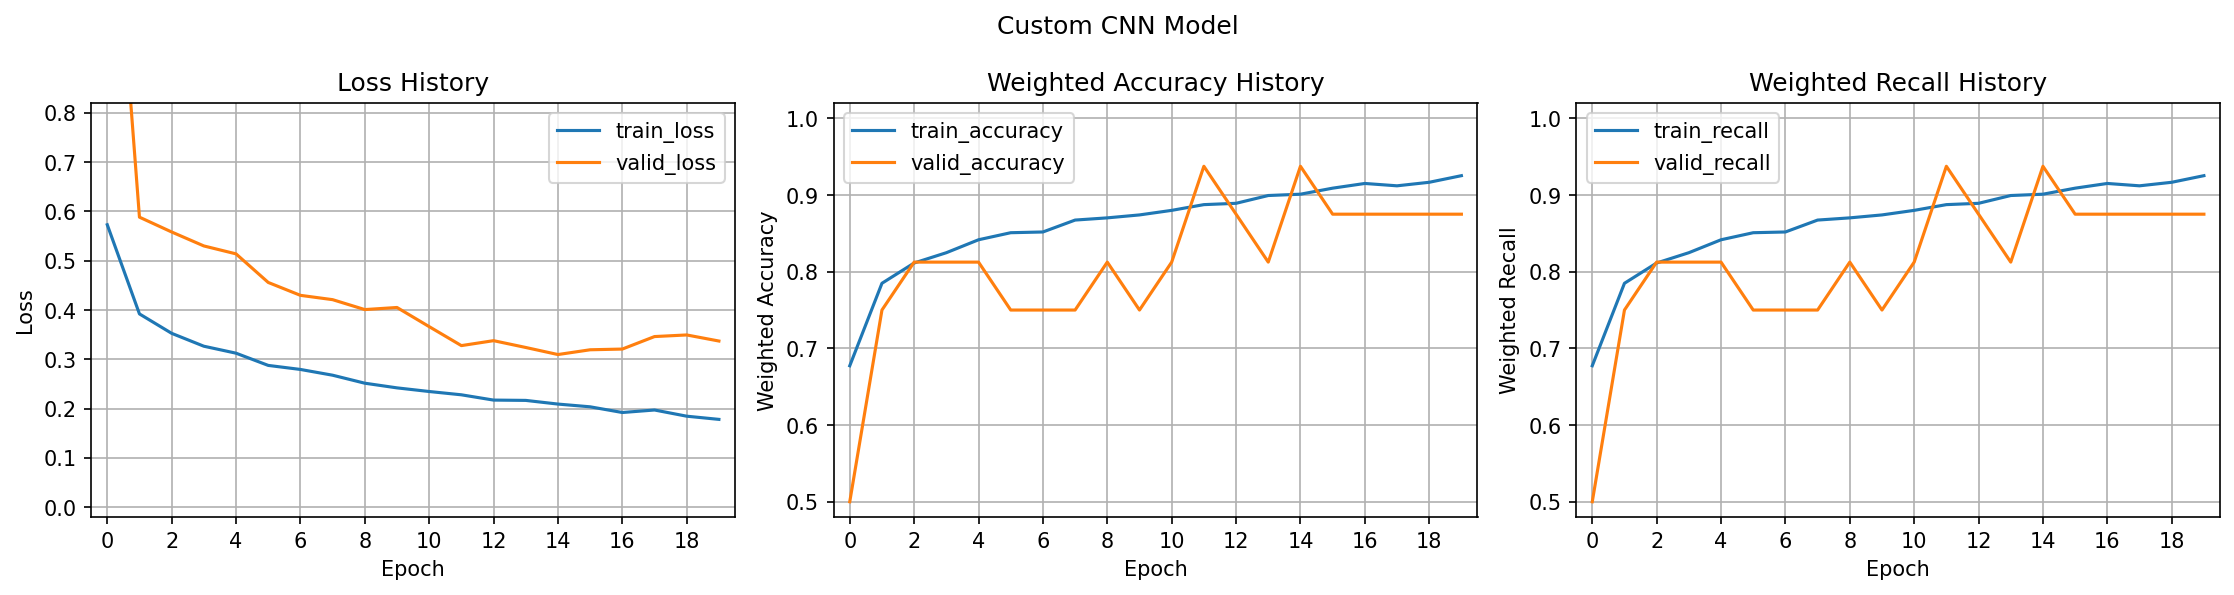

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4), dpi=150)
plt.suptitle("Custom CNN Model")
ax[0].plot(train_lists1['train_loss'], label='train_loss')
ax[0].plot(valid_lists1['valid_loss'], label='valid_loss')
ax[0].set_title('Loss History')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)
ax[0].set_xlim([-0.5, n_epoch-0.5])
ax[0].set_ylim([-0.02, 0.82])
ax[0].set_xticks(np.arange(0, n_epoch, step=2))

ax[1].plot(train_lists1['train_accuracy'], label='train_accuracy')
ax[1].plot(valid_lists1['valid_accuracy'], label='valid_accuracy')
ax[1].set_title('Weighted Accuracy History')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Weighted Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)
ax[1].set_xlim([-0.5, n_epoch-0.5])
ax[1].set_ylim([0.48, 1.02])
ax[1].set_xticks(np.arange(0, n_epoch, step=2))

ax[2].plot(train_lists1['train_recall'], label='train_recall')
ax[2].plot(valid_lists1['valid_recall'], label='valid_recall')
ax[2].set_title('Weighted Recall History')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Weighted Recall')
ax[2].legend(loc='best')
ax[2].grid(True)
ax[2].set_xlim([-0.5, n_epoch-0.5])
ax[2].set_ylim([0.48, 1.02])
ax[2].set_xticks(np.arange(0, n_epoch, step=2))

fig.tight_layout();

fig_filename = 'pneumonia_custom_model_' + f'_lr_{config.lr_custom}_bs_{config.batch_size}' + '.png'
fig.savefig(fig_filename)


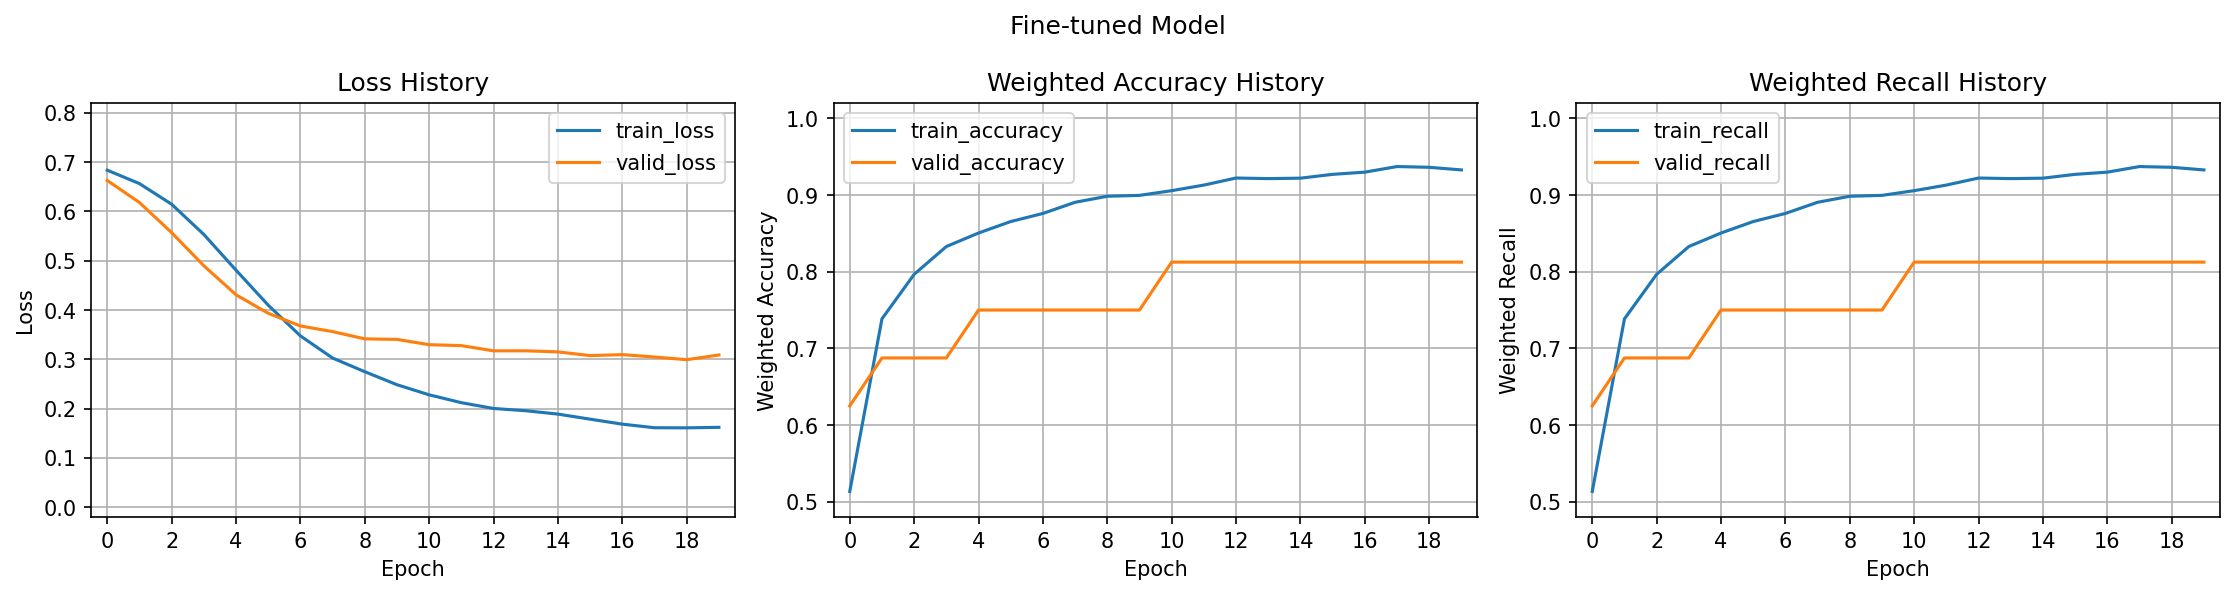

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4), dpi=150)
plt.suptitle("Fine-tuned Model")
ax[0].plot(train_lists2['train_loss'], label='train_loss')
ax[0].plot(valid_lists2['valid_loss'], label='valid_loss')
ax[0].set_title('Loss History')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)
ax[0].set_xlim([-0.5, n_epoch-0.5])
ax[0].set_ylim([-0.02, 0.82])
ax[0].set_xticks(np.arange(0, n_epoch, step=2))

ax[1].plot(train_lists2['train_accuracy'], label='train_accuracy')
ax[1].plot(valid_lists2['valid_accuracy'], label='valid_accuracy')
ax[1].set_title('Weighted Accuracy History')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Weighted Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)
ax[1].set_xlim([-0.5, n_epoch-0.5])
ax[1].set_ylim([0.48, 1.02])
ax[1].set_xticks(np.arange(0, n_epoch, step=2))

ax[2].plot(train_lists2['train_recall'], label='train_recall')
ax[2].plot(valid_lists2['valid_recall'], label='valid_recall')
ax[2].set_title('Weighted Recall History')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Weighted Recall')
ax[2].legend(loc='best')
ax[2].grid(True)
ax[2].set_xlim([-0.5, n_epoch-0.5])
ax[2].set_ylim([0.48, 1.02])
ax[2].set_xticks(np.arange(0, n_epoch, step=2))

fig.tight_layout();

fig_filename = 'pneumonia_pretrained_model_' + config.model_name + f'_lr_{config.lr_pretrained}_bs_{config.batch_size}' + '.png'
fig.savefig(fig_filename)


## Evaluate the performance on testset

In [45]:
status = cnn_model.load_state_dict(torch.load('pneumonia_cnn_model.pt', map_location=device, weights_only=True))
print(f"Status: {status}")

model_size = os.path.getsize('pneumonia_cnn_model.pt') / (1024 * 1024)  # in MB
print(f"Custom CNN model size: {model_size:.2f} MB")

test_metrics = cnn_trainer.valid_batch_loop(test_loader_custom)

print(f"Test Loss: {test_metrics.avg_loss:.3f}")
print(f"Test Acc.: {test_metrics.avg_accuracy:.3f}")
print(f"Test Recall: {test_metrics.avg_recall:.3f}")
print(f"Test Precision: {test_metrics.avg_precision:.3f}")
print(f"Test F1-score: {test_metrics.avg_f1_score:.3f}")

Status: <All keys matched successfully>
Custom CNN model size: 12.66 MB


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.317
Test Acc.: 0.894
Test Recall: 0.894
Test Precision: 0.896
Test F1-score: 0.895


In [46]:

save_filename_pretrained = 'pneumonia_pretrained_model_' + config.model_name + '.pt'
status = model.load_state_dict(torch.load('/content/' + save_filename_pretrained, map_location=device, weights_only=True))
print(f"Status: {status}")
print(f"save_filename_pretrained: {save_filename_pretrained}")

model_size = os.path.getsize(save_filename_pretrained) / (1024 * 1024)  # in MB
print(f"Pretrained model size: {model_size:.2f} MB")

test_metrics_pretrained = pretrained_trainer.valid_batch_loop(test_loader_pretrained)

print(f"Test Loss: {test_metrics_pretrained.avg_loss:.3f}")
print(f"Test Acc.: {test_metrics_pretrained.avg_accuracy:.3f}")
print(f"Test Recall: {test_metrics_pretrained.avg_recall:.3f}")
print(f"Test Precision: {test_metrics_pretrained.avg_precision:.3f}")
print(f"Test F1-score: {test_metrics_pretrained.avg_f1_score:.3f}")

Status: <All keys matched successfully>
save_filename_pretrained: pneumonia_pretrained_model_tf_efficientnet_b7.ap_in1k.pt
Pretrained model size: 255.98 MB


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.336
Test Acc.: 0.872
Test Recall: 0.872
Test Precision: 0.876
Test F1-score: 0.873


## Show the prediction for a sample image

In [47]:
def show_predicted_class(image, label_prob, label, mean, std, title):

    class_names = ['Normal', 'Pneumonia']

    label_prob = label_prob.cpu().detach().numpy().squeeze(0)

    image = image.to('cpu')
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor(mean)
    std = torch.FloatTensor(std)
    image = image*std + mean
    img = torch.clip(image, 0, 1)
    img = img.numpy()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,3), ncols=2, dpi=150)
    plt.suptitle(title)
    ax1.imshow(img, cmap="gray")
    ax1.set_title(f'Ground Truth: {class_names[label]}')
    ax1.axis(False)

    ax2.barh(class_names, label_prob)
    ax2.set_aspect(0.2)
    ax2.set_yticks(class_names)
    ax2.set_yticklabels(class_names)
    ax2.set_title(f'Predicted Class: {class_names[label_prob.argmax()]}')
    ax2.set_xlim(0, 1.05)

    plt.tight_layout()

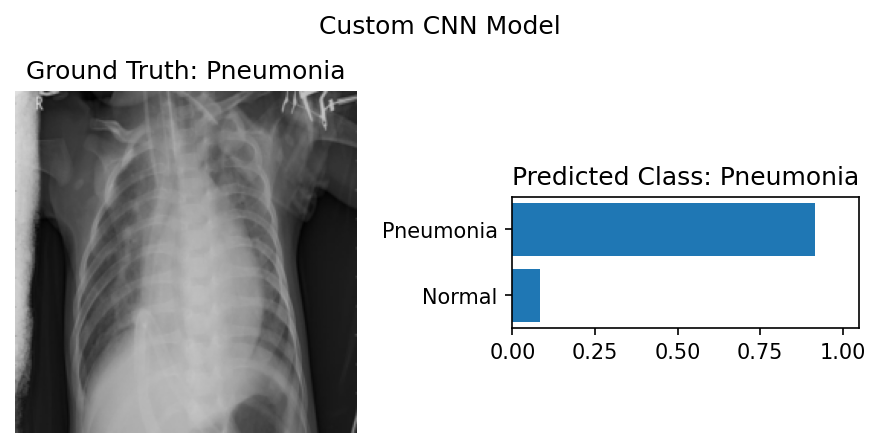

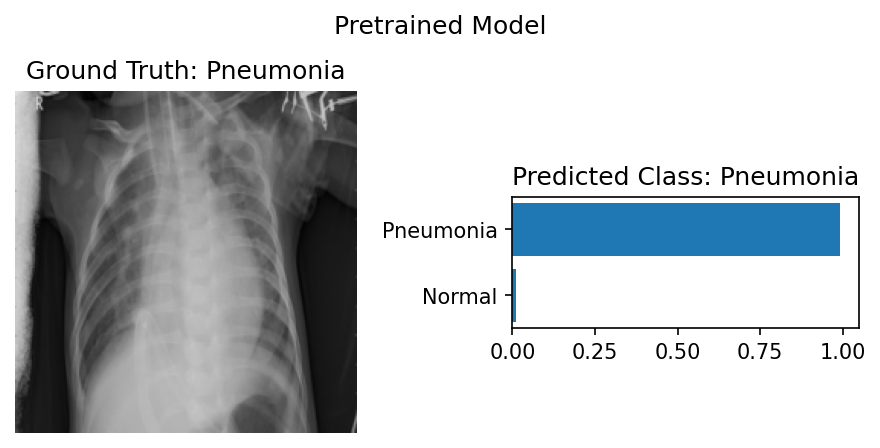

In [48]:
import random

random_int = random.randint(0, len(testset_custom)-1)
# For custom model
image, label = testset_custom[random_int]
image = image.to(device)

logit = cnn_model(image.unsqueeze(0))
label_predict = F.softmax(logit, dim = 1)

show_predicted_class(image, label_predict, label, config.pn_mean, config.pn_std, title="Custom CNN Model")

# For fine-tuned model
image, label = testset_pretrained[random_int]
image = image.to(device)

logit = model(image.unsqueeze(0))
label_predict = F.softmax(logit, dim = 1)

show_predicted_class(image, label_predict, label, config.in_mean, config.in_std, title="Pretrained Model")